📘 **Notebook 03
Exploratory Data Analysis, Feature Engineering & Dimensionality Reduction**

**1.Scope**

This part performs applied exploratory analysis and feature diagnostics to
prepare the dataset for downstream modeling. It focuses on:

- Applied exploratory data analysis (EDA) using training data only
- Distribution analysis of numeric and categorical features
- Feature–target relationship assessment
- Feature importance screening using filter and embedded methods
- Multicollinearity assessment
- Dimensionality reduction for diagnostic and visualisation purposes (PCA-style)

Out of scope for this notebook: data cleaning, preprocessing pipeline construction,
model training, hyperparameter tuning, SHAP/LIME explainability, and fairness metrics.



This notebook addresses the following capstone stage:

Step 3 – Applied EDA & Feature Engineering:
Exploratory analysis, feature diagnostics, feature selection, and dimensionality
reduction using leakage-safe training data.

This notebook intentionally does not cover:
- Data cleaning or preprocessing pipeline creation (Notebook 02)
- Model training, tuning, and evaluation (Notebook 04)
- Explainability and bias/fairness auditing (Notebook 05)
- Final communication and slide decks (Step 6)

Subsequent notebooks will cover:
- Notebook 04: Model implementation and comparison (baseline → tuned models)
- Notebook 05: Explainability (SHAP/LIME/PDP) and bias/fairness audit with mitigations

In [89]:
from google.colab import drive
drive.mount("/content/drive")

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import sparse
from scipy.sparse import load_npz

from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import TruncatedSVD


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Load Training Data**

All exploratory analysis is conducted only on the training set to avoid data leakage.

In [90]:
BASE_DIR = Path("/content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025")

MODELS_DIR = BASE_DIR / "models"                 # if you stored pipeline/artefacts here
PROCESSED_DIR = BASE_DIR / "outputs" / "processed"
DOCS_DIR = BASE_DIR / "docs"
DOCS_DIR.mkdir(parents=True, exist_ok=True)

print("BASE_DIR exists:", BASE_DIR.exists())
print("PROCESSED_DIR exists:", PROCESSED_DIR.exists())
print("DOCS_DIR exists:", DOCS_DIR.exists())

BASE_DIR exists: True
PROCESSED_DIR exists: True
DOCS_DIR exists: True


In [91]:
X_train_processed = load_npz(PROCESSED_DIR / "X_train_processed.npz")
X_test_processed  = load_npz(PROCESSED_DIR / "X_test_processed.npz")

y_train = pd.read_csv(PROCESSED_DIR / "y_train.csv").squeeze()
y_test  = pd.read_csv(PROCESSED_DIR / "y_test.csv").squeeze()

# (Optional) Load raw splits too (good for EDA/correlation)
X_train_raw = pd.read_csv(PROCESSED_DIR / "X_train_raw.csv")
X_test_raw  = pd.read_csv(PROCESSED_DIR / "X_test_raw.csv")

print("✅ Loaded processed matrices + labels + raw splits")
print("X_train_processed:", type(X_train_processed), X_train_processed.shape)
print("y_train:", y_train.shape, "Pos rate:", round(y_train.mean(), 4))
print("X_train_raw:", X_train_raw.shape)

✅ Loaded processed matrices + labels + raw splits
X_train_processed: <class 'scipy.sparse._csr.csr_matrix'> (81613, 2376)
y_train: (81613,) Pos rate: 0.1128
X_train_raw: (81613, 47)


**3. Numeric Feature Distributions and Outlier Screening**

This section examines the distributions of numeric features using training data only to assess:

- central tendency and dispersion,

- potential skewness and long-tailed behaviour, and

- the presence of extreme values that may influence downstream modelling.

These diagnostics inform later preprocessing decisions (e.g., scaling and robustness considerations) but do not apply transformations at this stage.

In [92]:
import numpy as np
import pandas as pd

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

print("Number of numeric columns:", len(numeric_cols))
print("Sample numeric columns:", numeric_cols[:15])

Number of numeric columns: 11
Sample numeric columns: ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


In [93]:
num_summary = X_train[numeric_cols].describe().T
num_summary["missing"] = X_train[numeric_cols].isna().sum()
num_summary["missing_pct"] = (num_summary["missing"] / len(X_train)) * 100

display(num_summary.sort_values("missing_pct", ascending=False).head(20))

,count,mean,std,min,25%,50%,75%,max,missing,missing_pct
admission_type_id,81613.0,2.028672,1.450590,1.0,1.0,1.0,3.0,8.0,0,0.0
discharge_disposition_id,81613.0,3.711075,5.268295,1.0,1.0,1.0,3.0,28.0,0,0.0
admission_source_id,81613.0,5.765001,4.072139,1.0,1.0,7.0,7.0,25.0,0,0.0
time_in_hospital,81613.0,4.397486,2.989373,1.0,2.0,4.0,6.0,14.0,0,0.0
num_lab_procedures,81613.0,43.081433,19.677812,1.0,31.0,44.0,57.0,132.0,0,0.0
num_procedures,81613.0,1.337054,1.706272,0.0,0.0,1.0,2.0,6.0,0,0.0
num_medications,81613.0,16.012302,8.123797,1.0,10.0,15.0,20.0,81.0,0,0.0
number_outpatient,81613.0,0.369353,1.268437,0.0,0.0,0.0,0.0,42.0,0,0.0
number_emergency,81613.0,0.198939,0.963761,0.0,0.0,0.0,0.0,76.0,0,0.0
number_inpatient,81613.0,0.641895,1.281984,0.0,0.0,0.0,1.0,21.0,0,0.0


In [94]:
def iqr_outlier_rate(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    rows = []
    for c in cols:
        s = df[c].dropna()
        if s.empty:
            continue

        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        if iqr == 0:
            # If IQR is zero, outlier rule isn't meaningful
            out_rate = 0.0
            lower, upper = np.nan, np.nan
        else:
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            out_rate = ((s < lower) | (s > upper)).mean()

        rows.append({
            "feature": c,
            "q1": q1,
            "q3": q3,
            "iqr": iqr,
            "lower_bound": lower,
            "upper_bound": upper,
            "outlier_rate": out_rate,
            "max": s.max(),
        })

    return pd.DataFrame(rows).sort_values("outlier_rate", ascending=False)

outlier_table = iqr_outlier_rate(X_train, numeric_cols)
display(outlier_table.head(20))


,feature,q1,q3,iqr,lower_bound,upper_bound,outlier_rate,max
1,discharge_disposition_id,1.0,3.0,2.0,-2.0,6.0,0.103660,28
9,number_inpatient,0.0,1.0,1.0,-1.5,2.5,0.069695,21
2,admission_source_id,1.0,7.0,6.0,-8.0,16.0,0.069021,25
5,num_procedures,0.0,2.0,2.0,-3.0,5.0,0.048558,6
6,num_medications,10.0,20.0,10.0,-5.0,35.0,0.025045,81
3,time_in_hospital,2.0,6.0,4.0,-4.0,12.0,0.022545,14
0,admission_type_id,1.0,3.0,2.0,-2.0,6.0,0.003406,8
10,number_diagnoses,6.0,9.0,3.0,1.5,13.5,0.002720,16
4,num_lab_procedures,31.0,57.0,26.0,-8.0,96.0,0.001348,132
8,number_emergency,0.0,0.0,0.0,NaN,NaN,0.000000,76


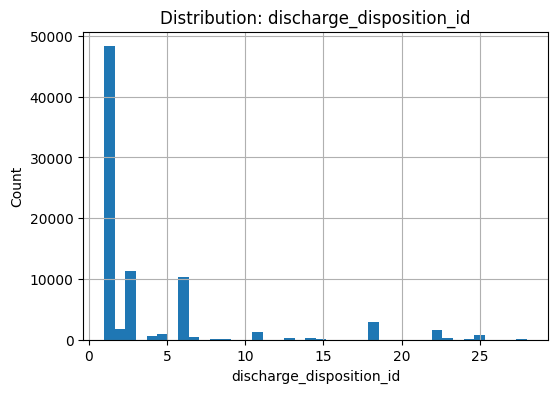

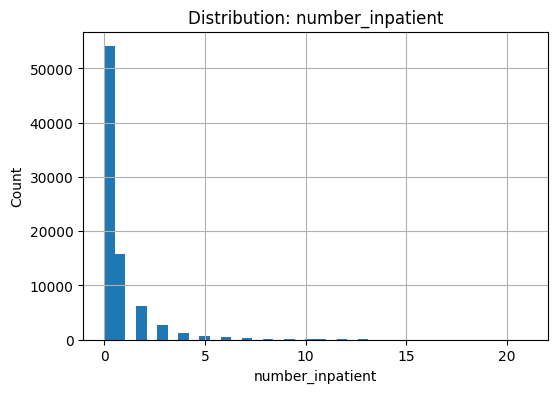

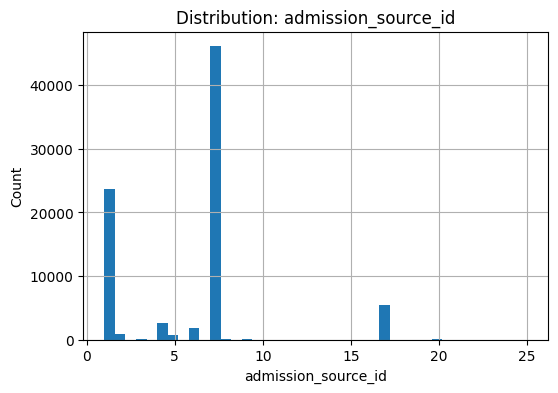

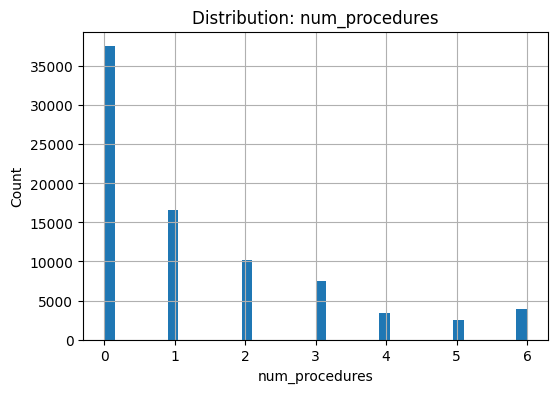

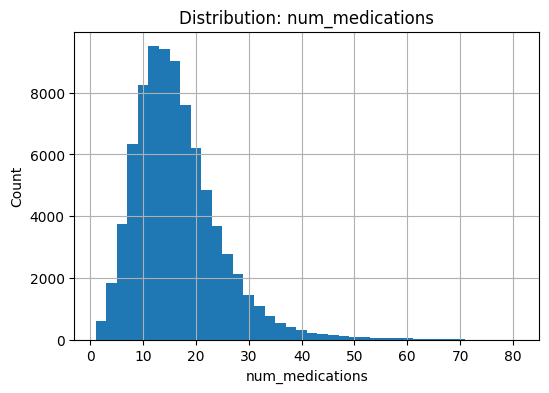

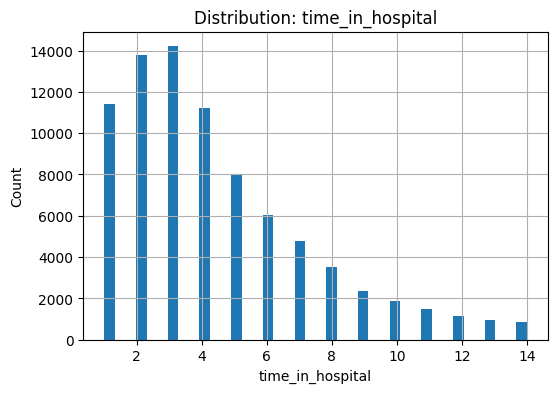

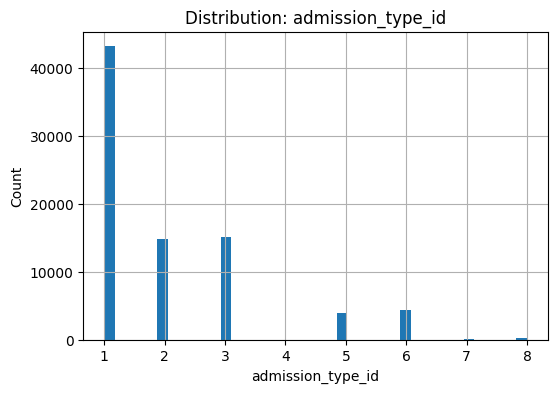

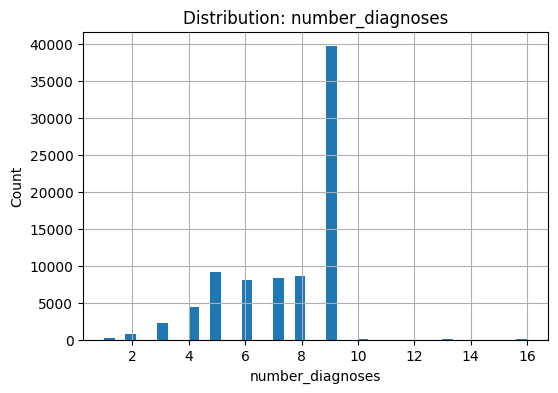

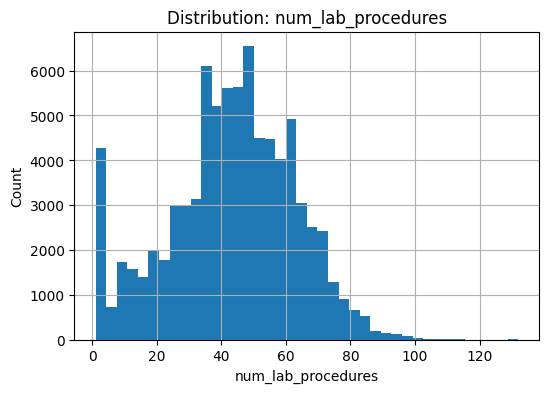

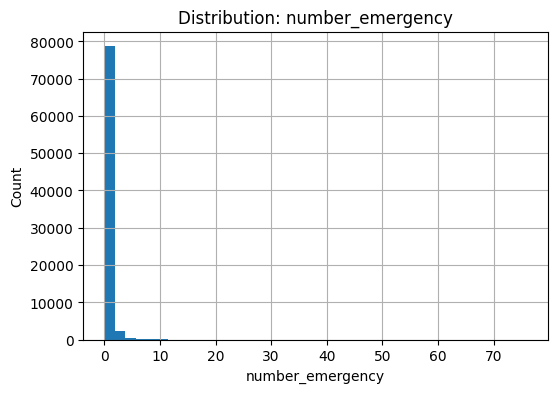

In [95]:
import matplotlib.pyplot as plt

top_outliers = outlier_table["feature"].head(10).tolist()

for c in top_outliers:
    plt.figure(figsize=(6, 4))
    X_train[c].dropna().hist(bins=40)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()

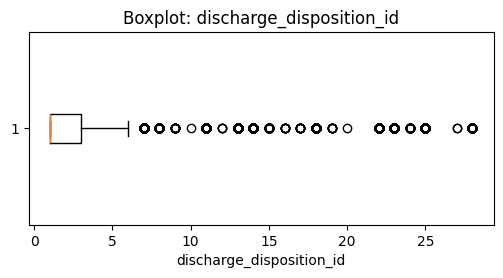

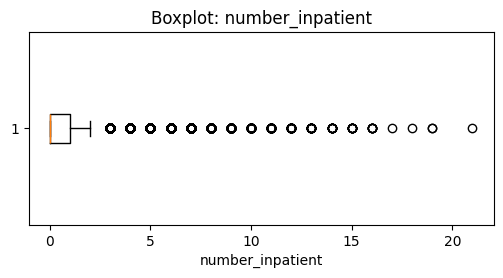

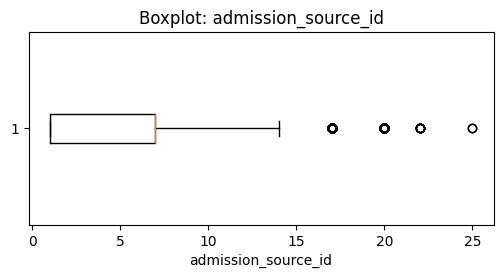

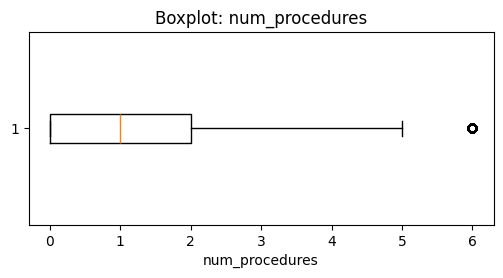

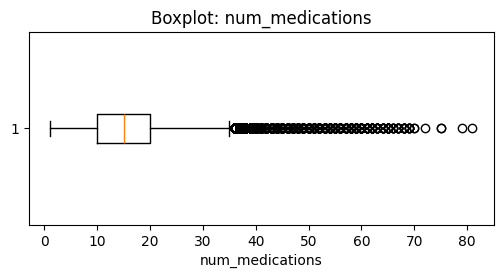

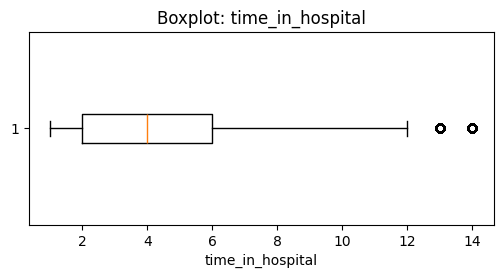

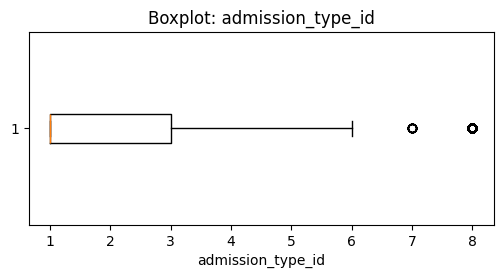

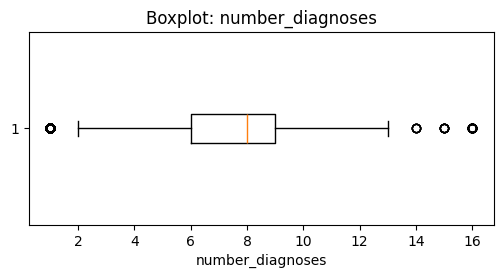

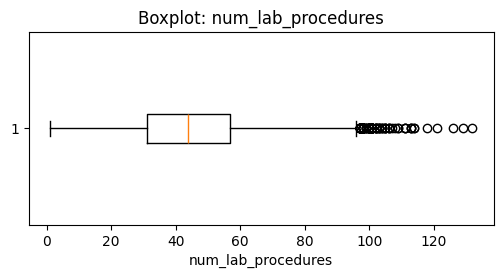

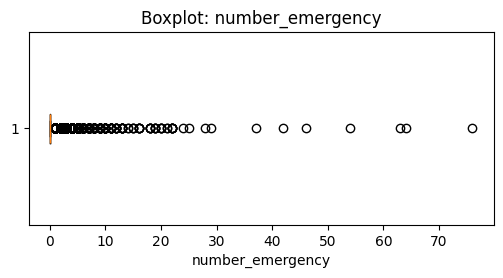

In [136]:
for c in top_outliers:
    plt.figure(figsize=(6, 2.5))
    plt.boxplot(X_train[c].dropna(), vert=False)
    plt.title(f"Boxplot: {c}")
    plt.xlabel(c)
    plt.show()

In [97]:
from pathlib import Path

DOCS_DIR = Path("/content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs")
DOCS_DIR.mkdir(parents=True, exist_ok=True)

num_summary_path = DOCS_DIR / "eda_numeric_summary.csv"
outlier_path = DOCS_DIR / "eda_numeric_outlier_screen.csv"

num_summary.to_csv(num_summary_path, index=True)
outlier_table.to_csv(outlier_path, index=False)

print("Saved:", num_summary_path)
print("Saved:", outlier_path)


Saved: /content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs/eda_numeric_summary.csv
Saved: /content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs/eda_numeric_outlier_screen.csv


**4. Numeric Features vs Target**

This section compares the distribution of selected numeric variables across readmission outcomes to identify potential predictive signals.

We use training data only (leakage-safe) and visualise:

- Group-wise descriptive statistics (mean/median/IQR)

- Boxplots for robust comparison across classes

- Optional: histograms/density-style overlays for selected features

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Ensure y_train is a 1D Series named 'target' ---
if isinstance(y_train, pd.DataFrame):
    # If a single-column DF
    if y_train.shape[1] == 1:
        y_series = y_train.iloc[:, 0]
    # If it has a known target column
    elif "readmitted_30d" in y_train.columns:
        y_series = y_train["readmitted_30d"]
    else:
        raise ValueError("y_train is a DataFrame with multiple columns. Please select the target column.")
else:
    y_series = y_train

y_series = y_series.rename("target")

# Combine into one analysis DataFrame (training only)
df_train = X_train_raw.copy()
df_train["target"] = y_series.values

# Quick target distribution
df_train["target"].value_counts(dropna=False)


,count
target,
0,72407
1,9206


In [99]:
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "target"]

# Optional: remove obvious ID-like fields if present (adjust list to your dataset)
id_like = {"encounter_id", "patient_nbr"}
numeric_cols = [c for c in numeric_cols if c not in id_like]

print("Numeric features (count):", len(numeric_cols))
numeric_cols[:15]


Numeric features (count): 11


['admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [100]:
group_summary = (
    df_train.groupby("target")[numeric_cols]
    .agg(["count", "mean", "median", "std"])
)

group_summary

admission_type_id                            discharge_disposition_id  \
                   count      mean median       std                    count   
target                                                                         
0                  72407  2.034237    1.0  1.453076                    72407   
1                   9206  1.984901    1.0  1.430213                     9206   

                                  admission_source_id            ...  \
            mean median       std               count      mean  ...   
target                                                           ...   
0       3.616764    1.0  5.152036               72407  5.757137  ...   
1       4.452857    2.0  6.055322                9206  5.826852  ...   

       number_emergency           number_inpatient                             \
                 median       std            count      mean median       std   
target                                                                          
0                   0.0  0.888194            72407  0.565111    0.0  1.134754   
1                   0.0  1.414529             9206  1.245818    0.0  2.007826   

       number_diagnoses                             
                  count      mean median       std  
target                                              
0                 72407  7.394934    8.0  1.946217  
1                  9206  7.686726    9.0  1.778333  

[2 rows x 44 columns]

In [101]:
# Choose key numeric features you want to inspect
# (You can also use numeric_cols[:10] but better to select meaningful ones)
focus_numeric = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses",
]

# Keep only those that exist
focus_numeric = [c for c in focus_numeric if c in df_train.columns]
print("Focus numeric features:", focus_numeric)

Focus numeric features: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


/tmp/ipython-input-489168500.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Readmit (0)", "Readmit (1)"])


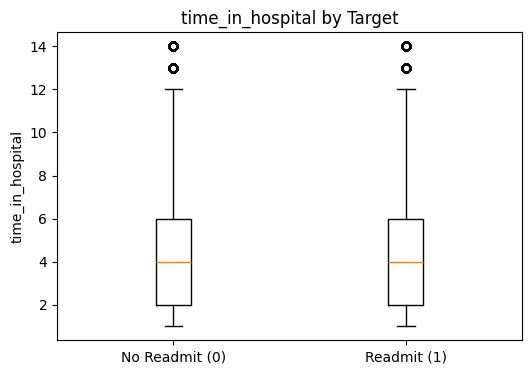

/tmp/ipython-input-489168500.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Readmit (0)", "Readmit (1)"])


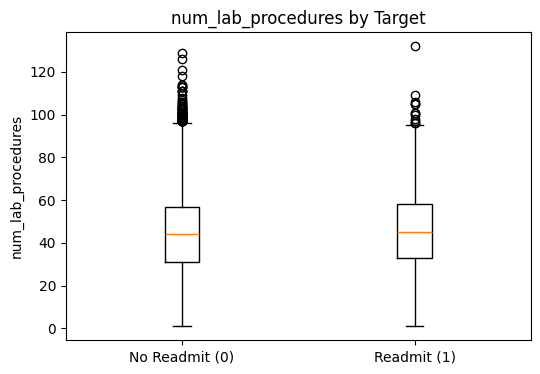

/tmp/ipython-input-489168500.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Readmit (0)", "Readmit (1)"])


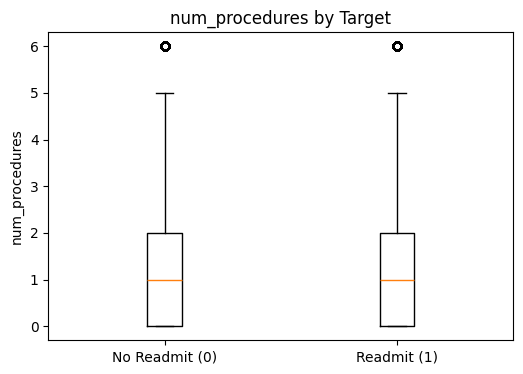

/tmp/ipython-input-489168500.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Readmit (0)", "Readmit (1)"])


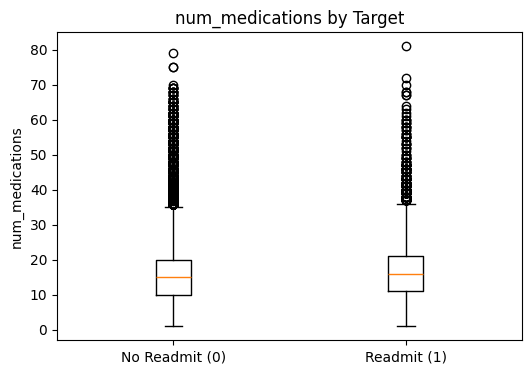

/tmp/ipython-input-489168500.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Readmit (0)", "Readmit (1)"])


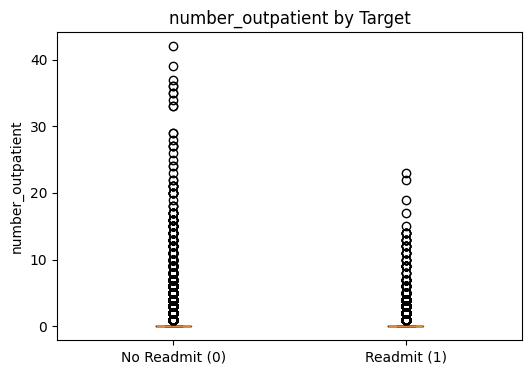

/tmp/ipython-input-489168500.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Readmit (0)", "Readmit (1)"])


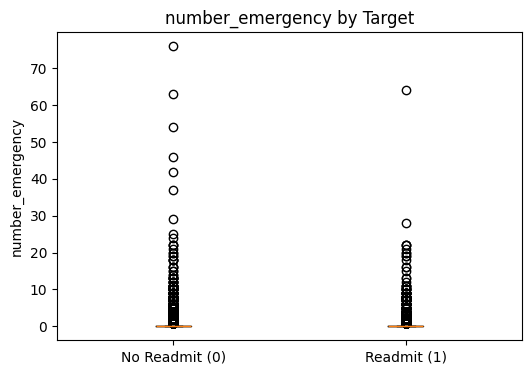

/tmp/ipython-input-489168500.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Readmit (0)", "Readmit (1)"])


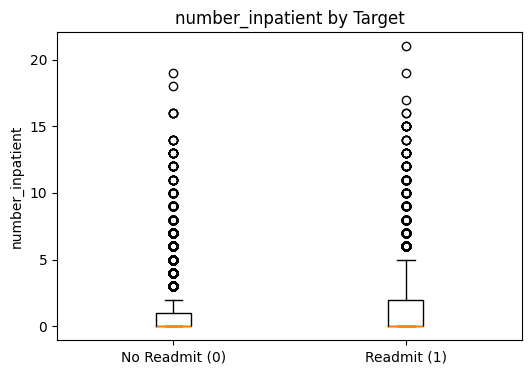

/tmp/ipython-input-489168500.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Readmit (0)", "Readmit (1)"])


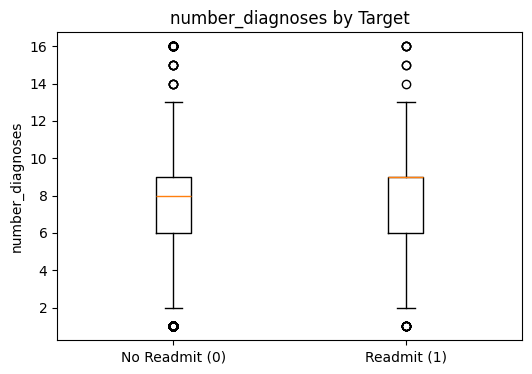

In [102]:
for col in focus_numeric:
    data0 = df_train.loc[df_train["target"] == 0, col].dropna()
    data1 = df_train.loc[df_train["target"] == 1, col].dropna()

    plt.figure(figsize=(6, 4))
    plt.boxplot([data0, data1], labels=["No Readmit (0)", "Readmit (1)"])
    plt.title(f"{col} by Target")
    plt.ylabel(col)
    plt.show()

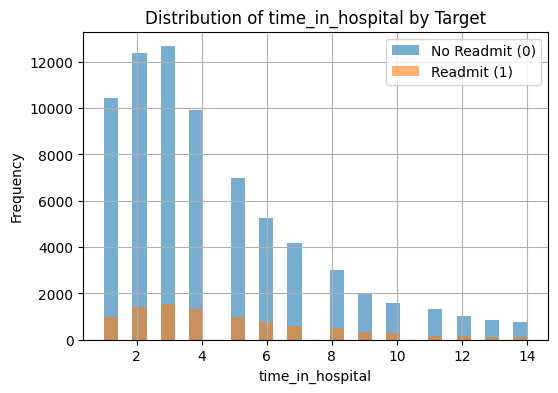

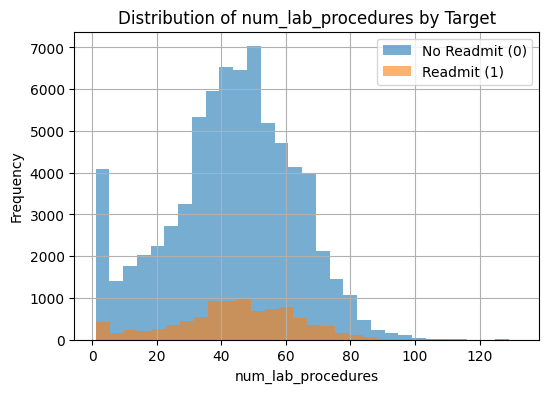

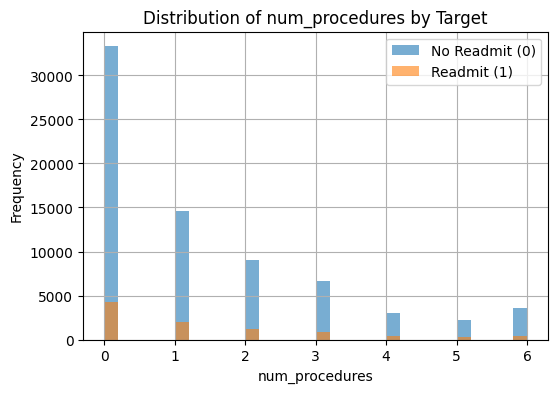

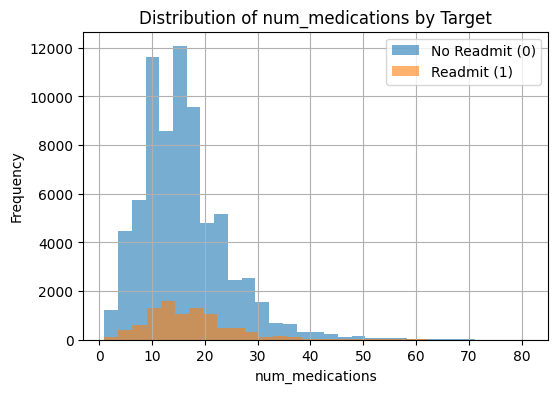

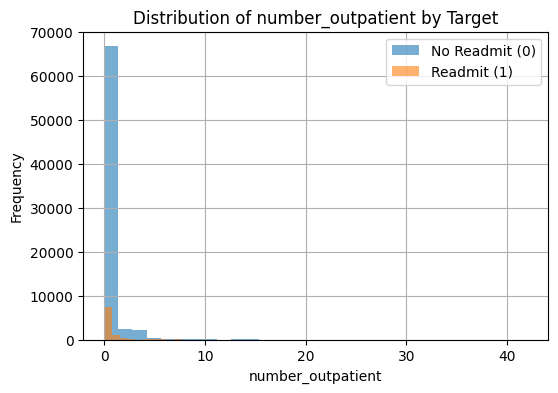

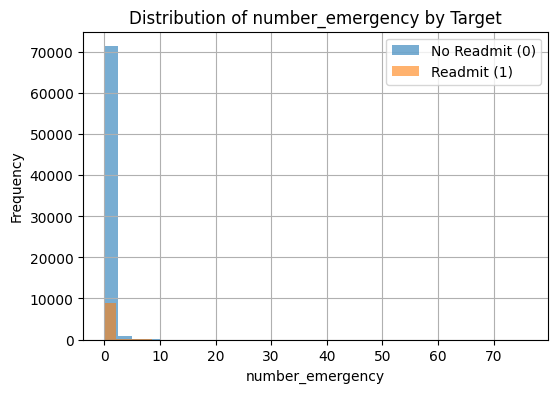

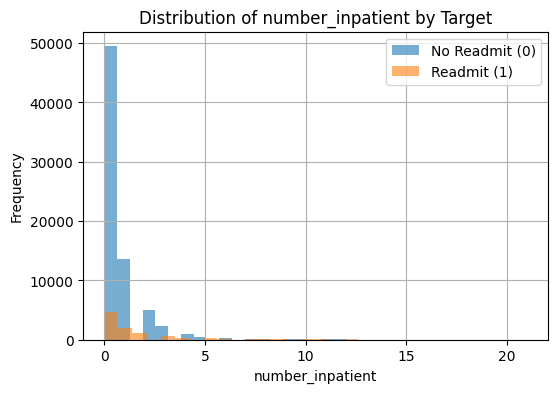

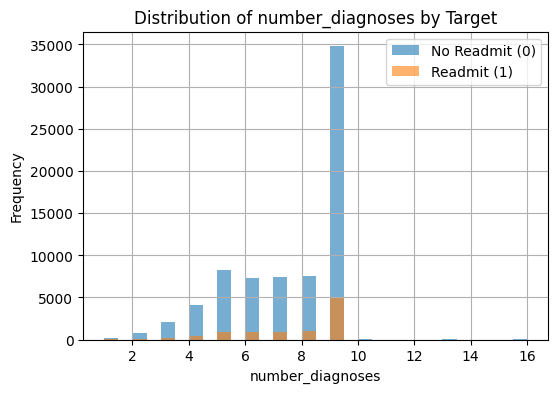

In [103]:
for col in focus_numeric:
    plt.figure(figsize=(6, 4))
    df_train.loc[df_train["target"] == 0, col].dropna().hist(alpha=0.6, bins=30)
    df_train.loc[df_train["target"] == 1, col].dropna().hist(alpha=0.6, bins=30)
    plt.title(f"Distribution of {col} by Target")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend(["No Readmit (0)", "Readmit (1)"])
    plt.show()

**5. Categorical Feature Distributions**

This section explores the distribution of selected categorical features and their association with 30-day readmission.

Using training data only (leakage-safe), we examine:

- Overall category frequencies

- Readmission rates by category

- Visual comparison of category-wise readmission proportions

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Identify categorical columns
categorical_cols = df_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("Number of categorical features:", len(categorical_cols))
categorical_cols[:10]

Number of categorical features: 36


['race',
 'gender',
 'age',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum']

In [105]:
for col in categorical_cols:
    print(f"\n=== {col} ===")
    display(df_train[col].value_counts(dropna=False).head(10))


=== race ===


,count
race,
Caucasian,61010
AfricanAmerican,15363
NaN,1863
Hispanic,1644
Other,1217
Asian,516



=== gender ===


,count
gender,
Female,43837
Male,37775
Unknown/Invalid,1



=== age ===


,count
age,
[70-80),20943
[60-70),17972
[80-90),13883
[50-60),13738
[40-50),7792
[30-40),2971
[90-100),2265
[20-30),1372
[10-20),554



=== weight ===


,count
weight,
NaN,79009
[75-100),1090
[50-75),737
[100-125),501
[125-150),120
[25-50),78
[0-25),37
[150-175),28
[175-200),10



=== payer_code ===


,count
payer_code,
NaN,32315
MC,26114
HM,5012
SP,3995
BC,3723
MD,2789
CP,1996
UN,1983
CM,1564



=== medical_specialty ===


,count
medical_specialty,
NaN,39835
InternalMedicine,11939
Emergency/Trauma,6149
Family/GeneralPractice,5972
Cardiology,4293
Surgery-General,2501
Nephrology,1255
Orthopedics,1105
Orthopedics-Reconstructive,976



=== diag_1 ===


,count
diag_1,
428,5503
414,5278
786,3224
410,2902
486,2840
427,2224
491,1835
715,1733
682,1677



=== diag_2 ===


,count
diag_2,
276,5418
428,5359
250,4830
427,4018
401,2989
496,2677
599,2669
403,2227
414,2157



=== diag_3 ===


,count
diag_3,
250,9292
401,6654
276,4202
428,3672
427,3136
414,2949
496,2095
403,1875
585,1590



=== max_glu_serum ===


,count
max_glu_serum,
NaN,77260
Norm,2124
>200,1227
>300,1002



=== A1Cresult ===


,count
A1Cresult,
NaN,67938
>8,6605
Norm,3982
>7,3088



=== metformin ===


,count
metformin,
No,65647
Steady,14697
Up,830
Down,439



=== repaglinide ===


,count
repaglinide,
No,80371
Steady,1116
Up,87
Down,39



=== nateglinide ===


,count
nateglinide,
No,81039
Steady,543
Up,23
Down,8



=== chlorpropamide ===


,count
chlorpropamide,
No,81542
Steady,65
Up,5
Down,1



=== glimepiride ===


,count
glimepiride,
No,77499
Steady,3703
Up,260
Down,151



=== acetohexamide ===


,count
acetohexamide,
No,81613



=== glipizide ===


,count
glipizide,
No,71379
Steady,9157
Up,621
Down,456



=== glyburide ===


,count
glyburide,
No,73158
Steady,7392
Up,634
Down,429



=== tolbutamide ===


,count
tolbutamide,
No,81594
Steady,19



=== pioglitazone ===


,count
pioglitazone,
No,75772
Steady,5556
Up,189
Down,96



=== rosiglitazone ===


,count
rosiglitazone,
No,76524
Steady,4870
Up,144
Down,75



=== acarbose ===


,count
acarbose,
No,81370
Steady,232
Up,8
Down,3



=== miglitol ===


,count
miglitol,
No,81582
Steady,25
Down,5
Up,1



=== troglitazone ===


,count
troglitazone,
No,81610
Steady,3



=== tolazamide ===


,count
tolazamide,
No,81583
Steady,30



=== examide ===


,count
examide,
No,81613



=== citoglipton ===


,count
citoglipton,
No,81613



=== insulin ===


,count
insulin,
No,37918
Steady,24730
Down,9848
Up,9117



=== glyburide-metformin ===


,count
glyburide-metformin,
No,81031
Steady,571
Up,7
Down,4



=== glipizide-metformin ===


,count
glipizide-metformin,
No,81601
Steady,12



=== glimepiride-pioglitazone ===


,count
glimepiride-pioglitazone,
No,81612
Steady,1



=== metformin-rosiglitazone ===


,count
metformin-rosiglitazone,
No,81611
Steady,2



=== metformin-pioglitazone ===


,count
metformin-pioglitazone,
No,81613



=== change ===


,count
change,
No,43901
Ch,37712



=== diabetesMed ===


,count
diabetesMed,
Yes,62896
No,18717


In [106]:
cat_target_summary = {}

for col in categorical_cols:
    summary = (
        df_train.groupby(col)["target"]
        .agg(
            count="count",
            readmission_rate="mean"
        )
        .sort_values("readmission_rate", ascending=False)
    )
    cat_target_summary[col] = summary

# Example: show one table
first_col = categorical_cols[0]
cat_target_summary[first_col].head(10)

,count,readmission_rate
race,,
Caucasian,61010,0.114178
AfricanAmerican,15363,0.112608
Hispanic,1644,0.110097
Other,1217,0.095316
Asian,516,0.089147


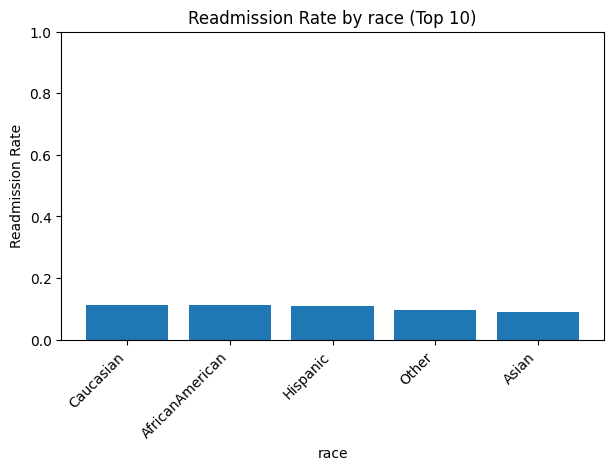

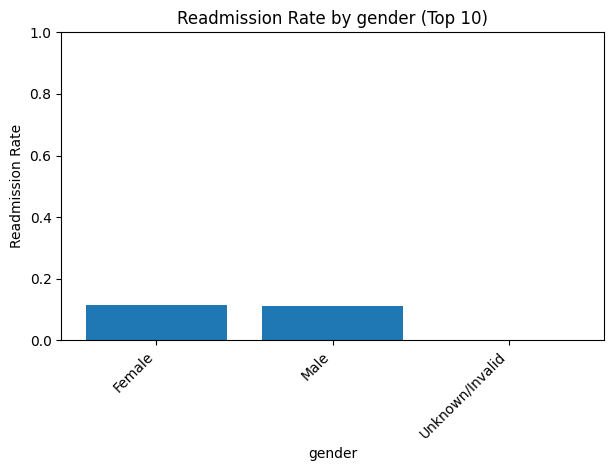

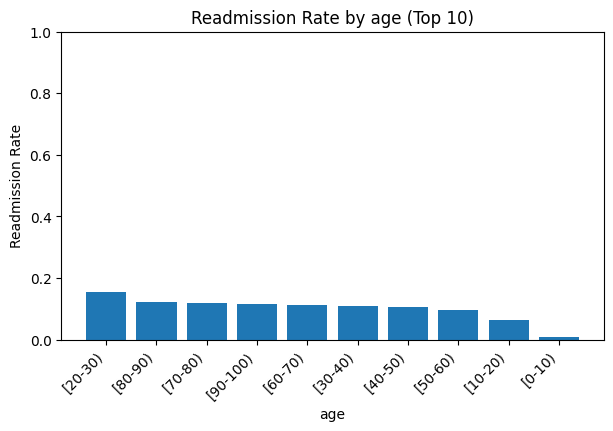

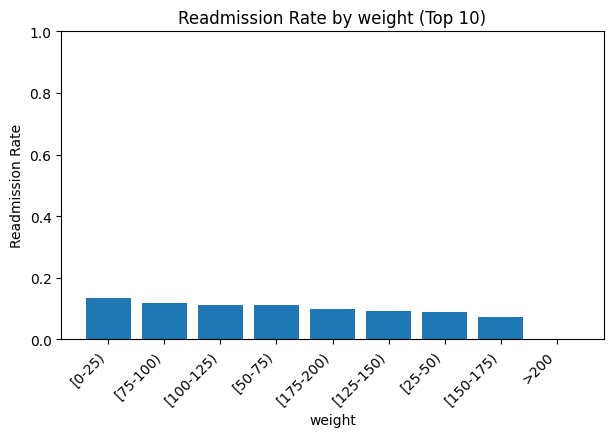

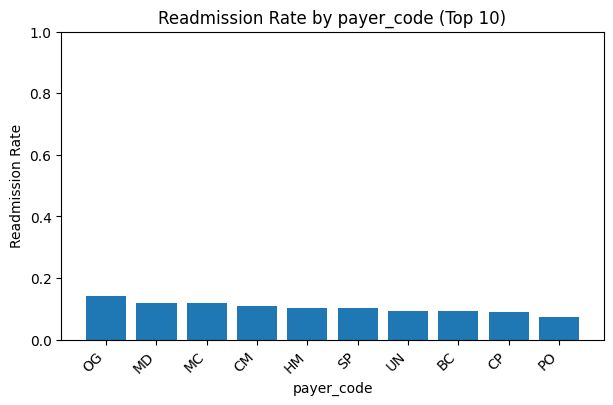

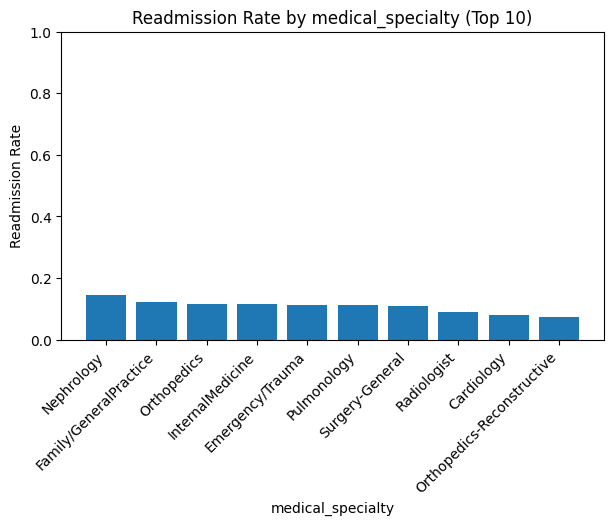

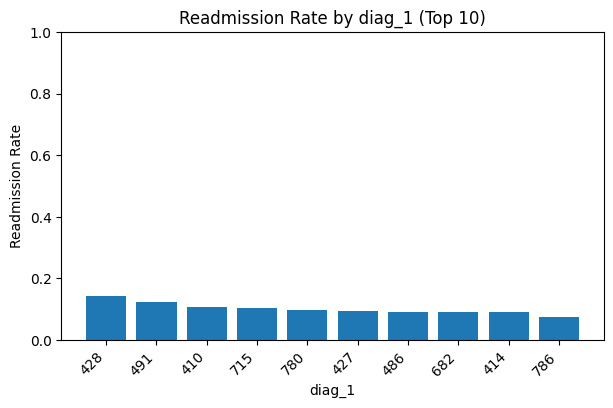

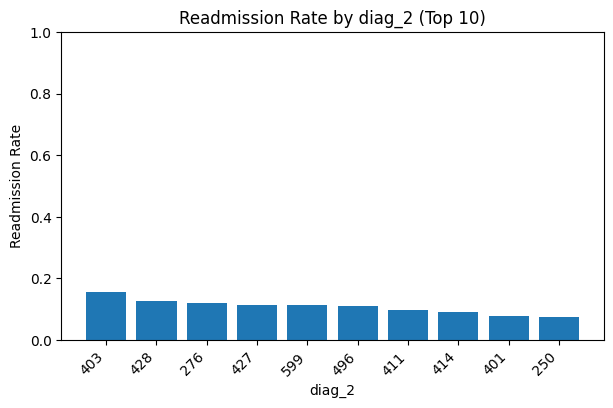

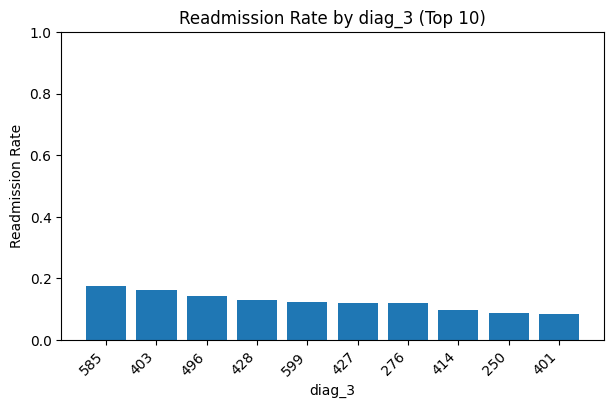

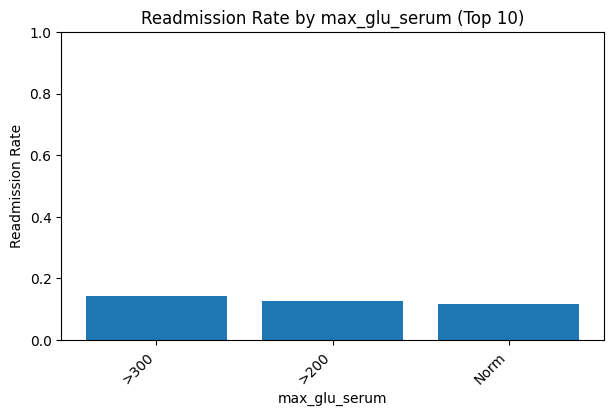

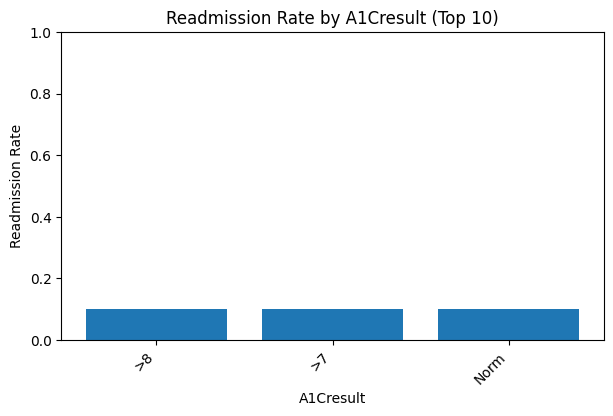

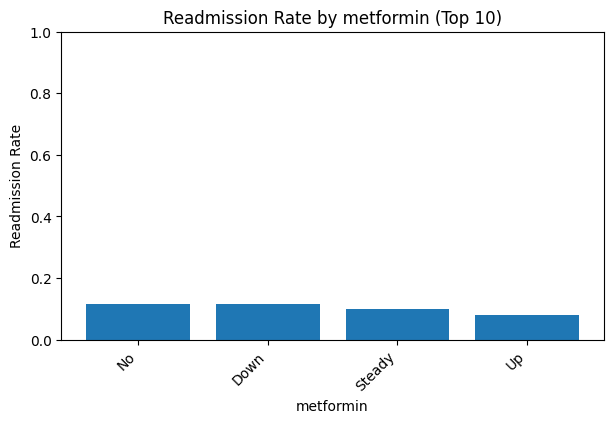

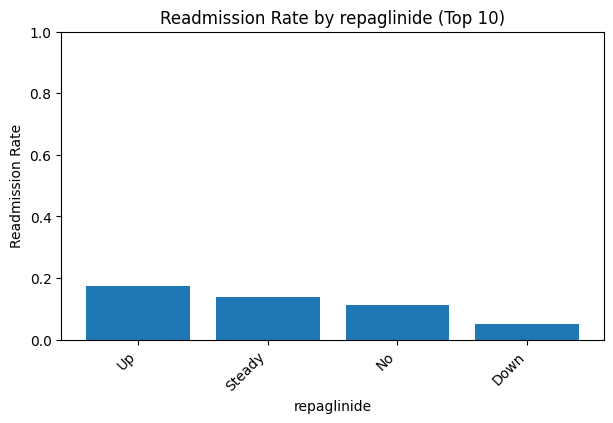

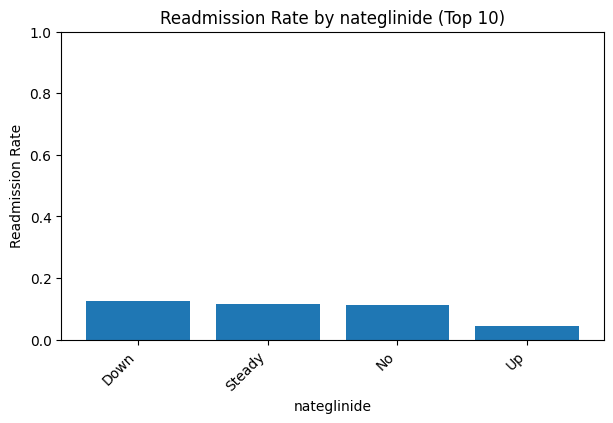

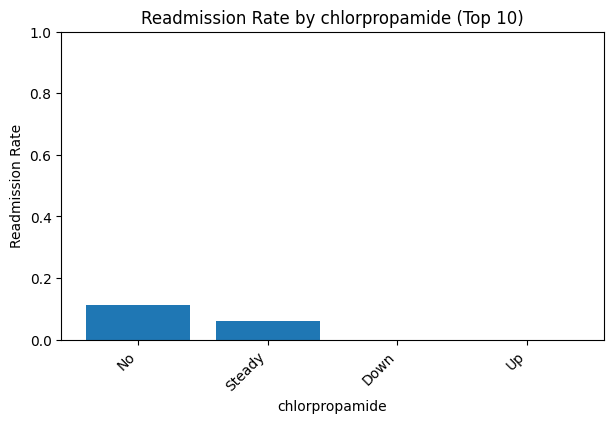

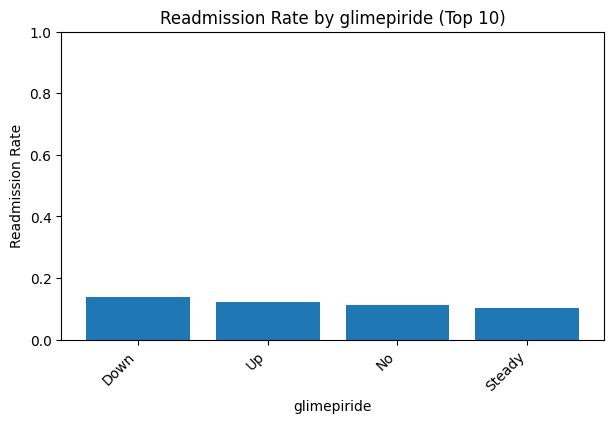

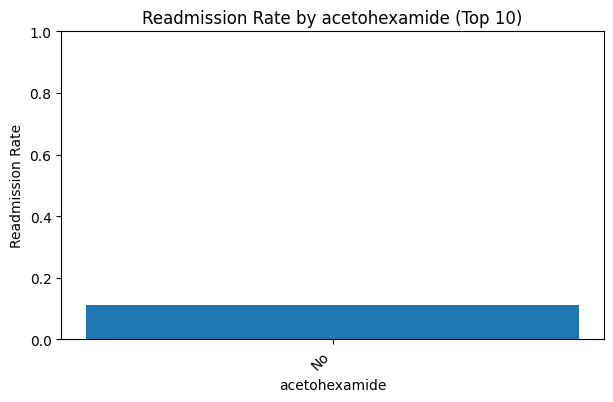

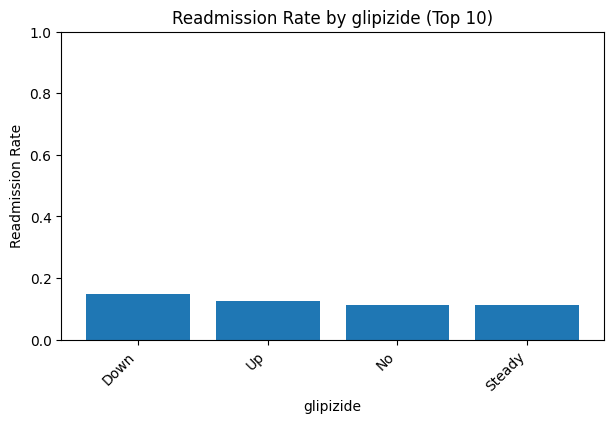

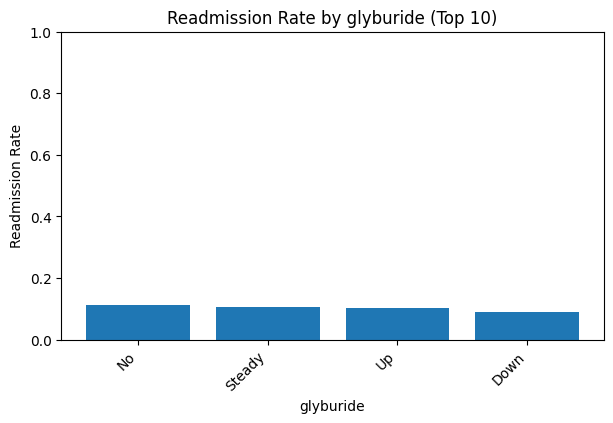

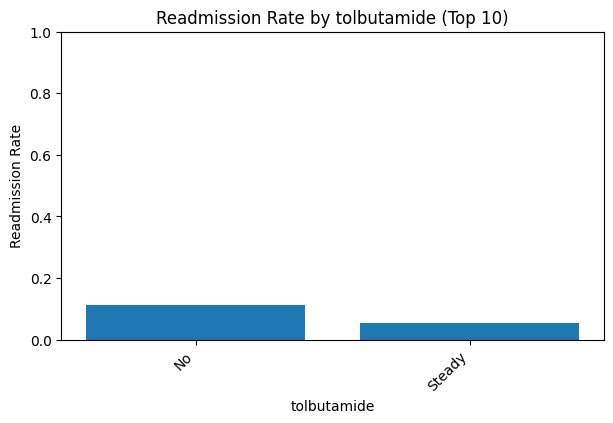

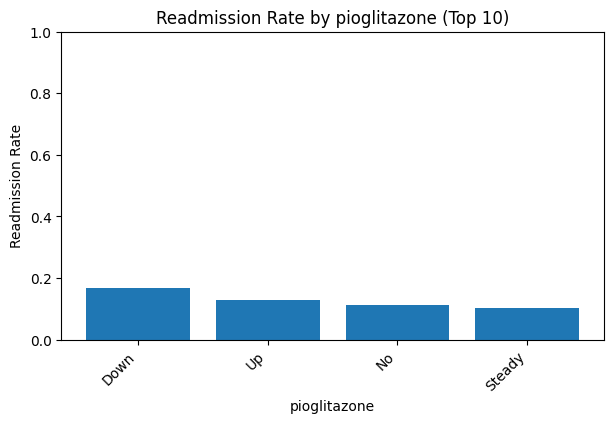

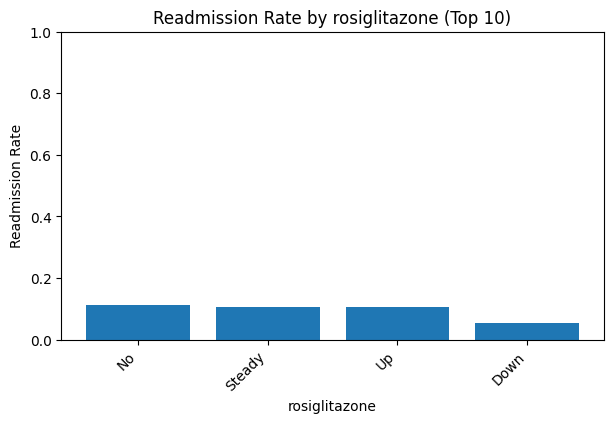

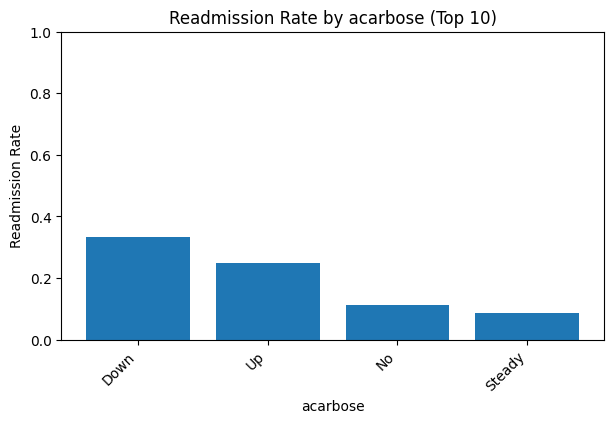

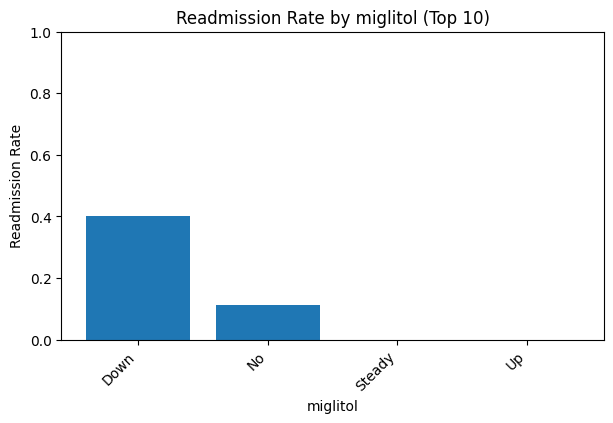

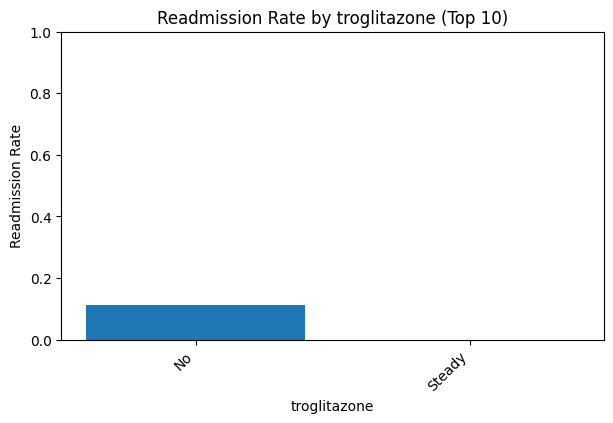

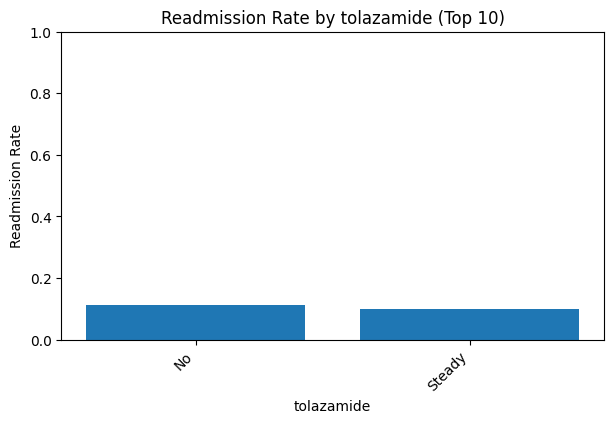

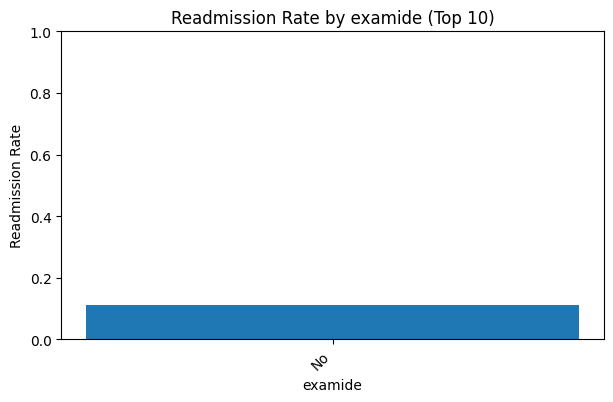

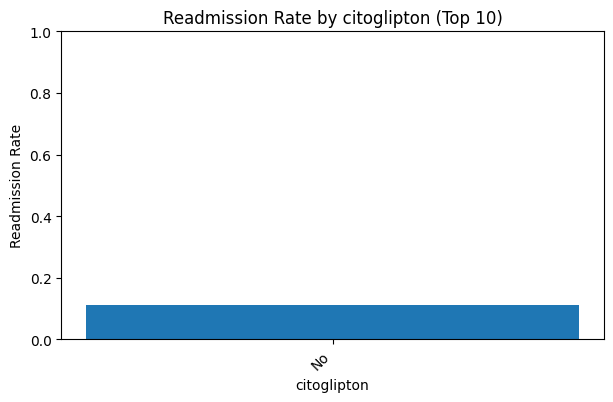

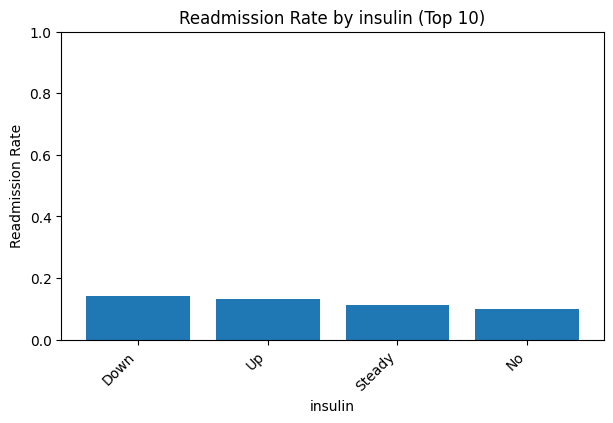

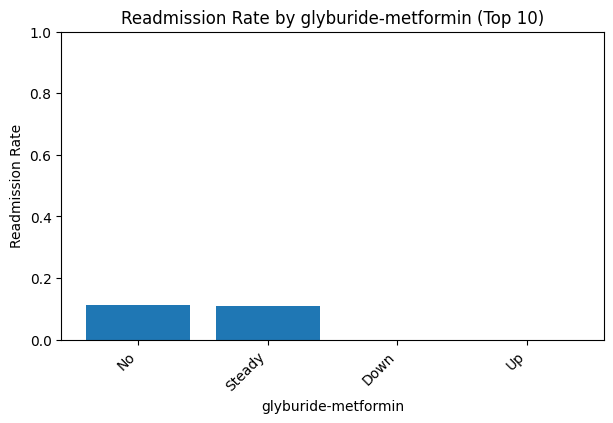

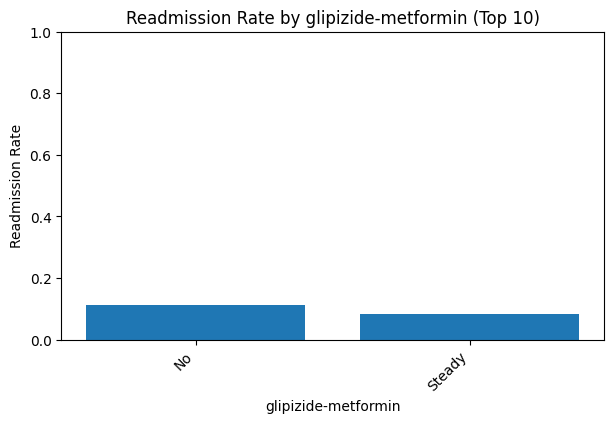

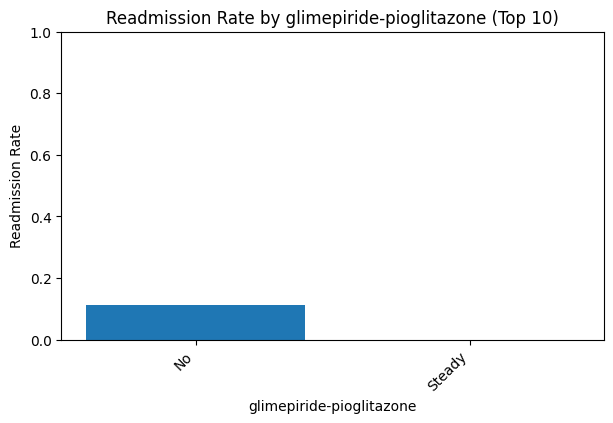

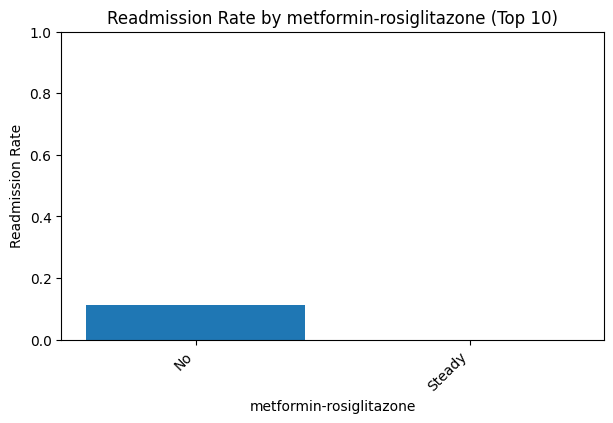

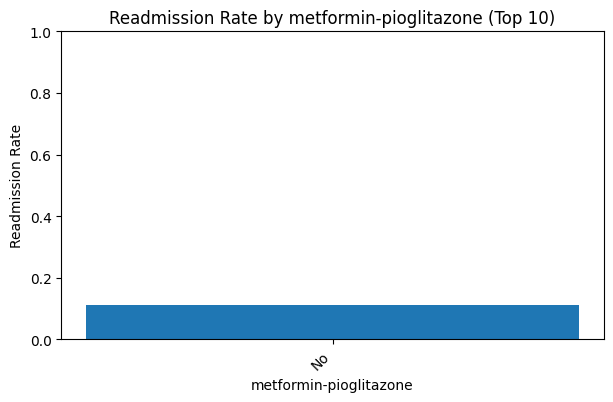

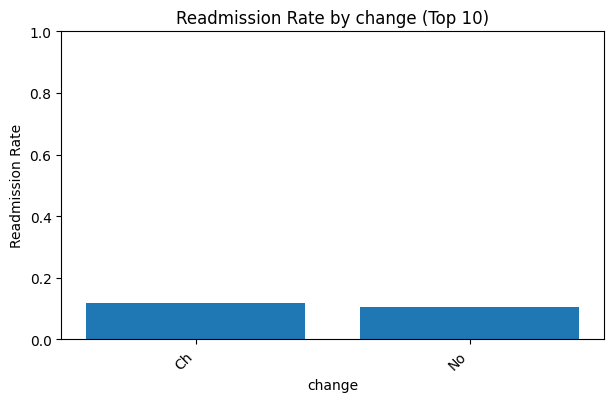

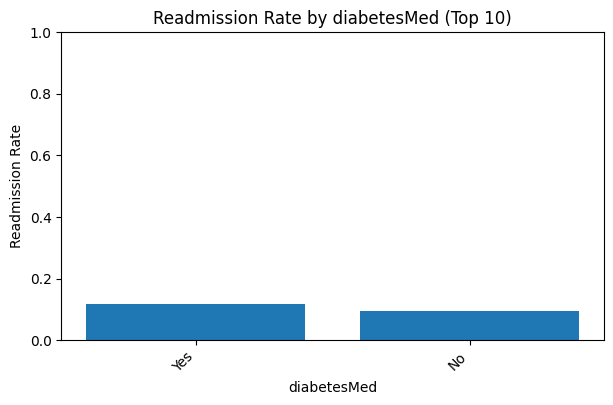

In [107]:
TOP_N = 10

for col in categorical_cols:
    summary = cat_target_summary[col].copy()

    # Keep most frequent categories only
    top_categories = (
        df_train[col]
        .value_counts()
        .head(TOP_N)
        .index
    )

    plot_df = summary.loc[summary.index.isin(top_categories)]

    plt.figure(figsize=(7, 4))
    plt.bar(plot_df.index.astype(str), plot_df["readmission_rate"])
    plt.title(f"Readmission Rate by {col} (Top {TOP_N})")
    plt.ylabel("Readmission Rate")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.show()

In [108]:
for col in categorical_cols[:5]:  # limit to first 5 to keep output readable
    print(f"\nCross-tabulation: {col}")
    display(pd.crosstab(df_train[col], df_train["target"], normalize="index"))


Cross-tabulation: race


target,0,1
race,,
AfricanAmerican,0.887392,0.112608
Asian,0.910853,0.089147
Caucasian,0.885822,0.114178
Hispanic,0.889903,0.110097
Other,0.904684,0.095316



Cross-tabulation: gender


target,0,1
gender,,
Female,0.886055,0.113945
Male,0.888524,0.111476
Unknown/Invalid,1.000000,0.000000



Cross-tabulation: age


target,0,1
age,,
[0-10),0.991870,0.008130
[10-20),0.936823,0.063177
[20-30),0.844752,0.155248
[30-40),0.890609,0.109391
[40-50),0.892967,0.107033
[50-60),0.904498,0.095502
[60-70),0.886657,0.113343
[70-80),0.880199,0.119801
[80-90),0.879349,0.120651



Cross-tabulation: weight


target,0,1
weight,,
>200,1.000000,0.000000
[0-25),0.864865,0.135135
[100-125),0.888224,0.111776
[125-150),0.908333,0.091667
[150-175),0.928571,0.071429
[175-200),0.900000,0.100000
[25-50),0.910256,0.089744
[50-75),0.888738,0.111262
[75-100),0.882569,0.117431



Cross-tabulation: payer_code


target,0,1
payer_code,,
BC,0.908407,0.091593
CH,0.913793,0.086207
CM,0.890026,0.109974
CP,0.910822,0.089178
DM,0.904878,0.095122
HM,0.897247,0.102753
MC,0.881443,0.118557
MD,0.880244,0.119756
MP,0.888889,0.111111


**6. Correlation Analysis (Numeric Features)**

Highly correlated numeric variables may increase model variance, reduce interpretability, and introduce redundant information.

This section examines pairwise correlations among numeric features using training data only to:

- Identify strongly correlated feature pairs

- Assess potential multicollinearity risks

- Inform later feature selection or regularisation decisions

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure target is excluded
numeric_corr_cols = [c for c in numeric_cols if c != "target"]

X_num = df_train[numeric_corr_cols].copy()
print("Numeric features used for correlation:", len(numeric_corr_cols))

Numeric features used for correlation: 11


In [110]:
corr_matrix = X_num.corr(method="pearson")

# Preview strongest correlations
corr_matrix.abs().unstack().sort_values(ascending=False).head(15)

,,0
admission_type_id,admission_type_id,1.000000
admission_source_id,admission_source_id,1.000000
discharge_disposition_id,discharge_disposition_id,1.000000
num_lab_procedures,num_lab_procedures,1.000000
time_in_hospital,time_in_hospital,1.000000
number_emergency,number_emergency,1.000000
number_outpatient,number_outpatient,1.000000
num_medications,num_medications,1.000000
num_procedures,num_procedures,1.000000
number_diagnoses,number_diagnoses,1.000000


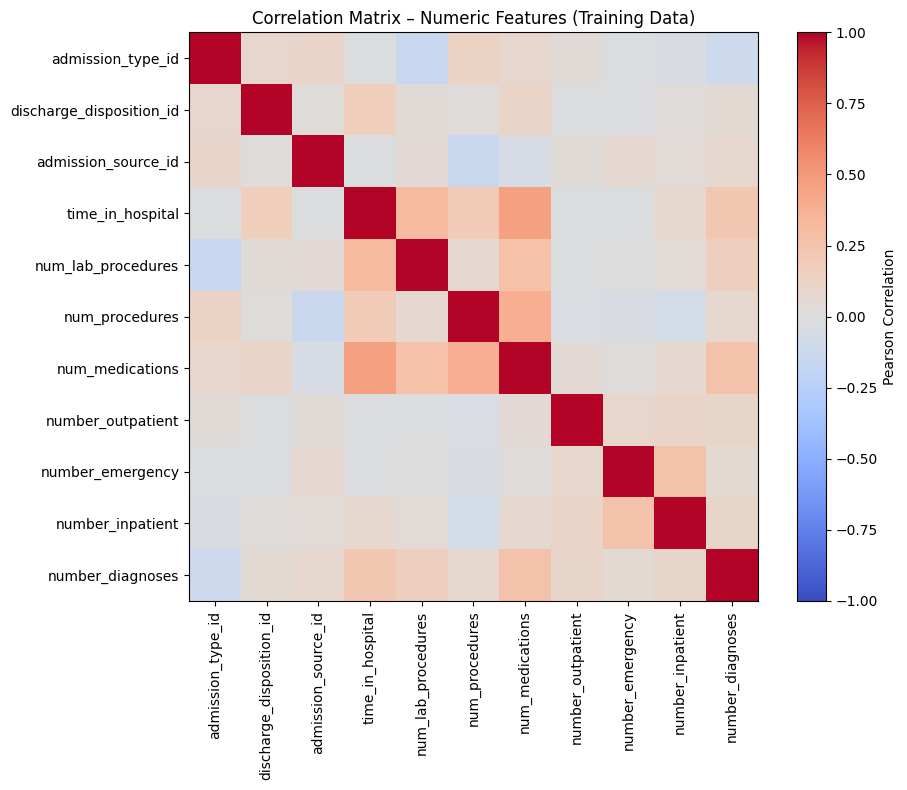

In [111]:
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Pearson Correlation")
plt.title("Correlation Matrix – Numeric Features (Training Data)")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.tight_layout()
plt.show()

In [112]:
# Extract upper triangle of correlation matrix
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "correlation"})
)

# Filter strong correlations
HIGH_CORR_THRESHOLD = 0.75
high_corr_pairs = high_corr_pairs.loc[
    high_corr_pairs["correlation"].abs() >= HIGH_CORR_THRESHOLD
].sort_values("correlation", ascending=False)

high_corr_pairs

,feature_1,feature_2,correlation


In [113]:
TOP_K = 3

for _, row in high_corr_pairs.head(TOP_K).iterrows():
    f1, f2 = row["feature_1"], row["feature_2"]

    plt.figure(figsize=(5, 4))
    plt.scatter(df_train[f1], df_train[f2], alpha=0.4)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f"Scatter Plot: {f1} vs {f2}")
    plt.show()

**7. Feature Relevance Screening (Mutual Information, Leakage-Safe)**

This section evaluates the relevance of individual features to the 30-day readmission target
using Mutual Information (MI). MI captures both linear and non-linear dependencies and is
computed on the leakage-safe, preprocessed training data only.

This analysis is used for feature diagnostics and ranking, not for final model selection.


In [114]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.feature_selection import mutual_info_classif

# Work on training data only
X_mi = X_train_processed
y_mi = y_train.values if hasattr(y_train, "values") else np.asarray(y_train)

# Optional sampling to control memory in Colab
MAX_ROWS_FOR_MI = 50000
if X_mi.shape[0] > MAX_ROWS_FOR_MI:
    rng = np.random.default_rng(42)
    idx = rng.choice(X_mi.shape[0], size=MAX_ROWS_FOR_MI, replace=False)
    X_mi = X_mi[idx]
    y_mi = y_mi[idx]

# MI is safest on dense input for mixed data
if sparse.issparse(X_mi):
    X_mi = X_mi.toarray()

print("MI input shape:", X_mi.shape)

MI input shape: (50000, 2376)


In [115]:
mi_scores = mutual_info_classif(
    X_mi,
    y_mi,
    discrete_features="auto",  # correct for one-hot + scaled numeric mix
    random_state=42
)

mi_scores_df = (
    pd.DataFrame({
        "feature": feature_names,
        "mutual_information": mi_scores
    })
    .sort_values("mutual_information", ascending=False)
    .reset_index(drop=True)
)

mi_scores_df.head(15)

,feature,mutual_information
0,cat__repaglinide_No,0.013446
1,num__number_inpatient,0.013108
2,cat__rosiglitazone_No,0.012321
3,cat__tolbutamide_No,0.012056
4,cat__chlorpropamide_No,0.011429
5,cat__glimepiride_No,0.011401
6,cat__acarbose_No,0.011090
7,cat__citoglipton_No,0.010894
8,cat__troglitazone_No,0.010657
9,cat__payer_code_MC,0.010550


In [116]:
from pathlib import Path

DOCS_DIR = Path("/content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs")
DOCS_DIR.mkdir(parents=True, exist_ok=True)

top_mi_path = DOCS_DIR / "top_mi_features.csv"
mi_scores_df.head(50).to_csv(top_mi_path, index=False)

print("Saved top MI features to:", top_mi_path)

Saved top MI features to: /content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs/top_mi_features.csv


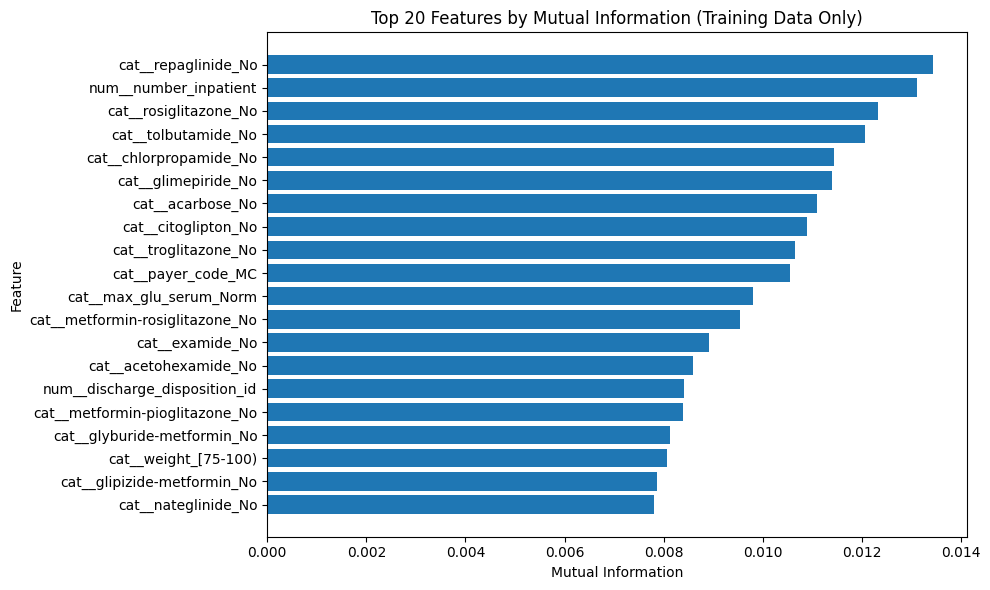

In [117]:
import matplotlib.pyplot as plt

top_plot = mi_scores_df.head(20).iloc[::-1]  # reverse for horizontal bars

plt.figure(figsize=(10, 6))
plt.barh(top_plot["feature"], top_plot["mutual_information"])
plt.title("Top 20 Features by Mutual Information (Training Data Only)")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [118]:
if MODELS_DIR.exists():
    print("Files in models/:")
    for f in MODELS_DIR.iterdir():
        print(" -", f.name)
else:
    print("❌ models/ directory not found")


Files in models/:
 - preprocess_pipeline.joblib


**8. Feature Selection: Embedded Method (Random Forest)**

Tree-based models provide embedded feature importance estimates by measuring how much each feature contributes to reducing impurity during training. Unlike filter methods, they can capture non-linear interactions and feature dependencies.

In this section, a Random Forest classifier is trained on the leakage-safe, preprocessed training data only to obtain embedded feature importance scores. These scores are used for diagnostic comparison with Mutual Information results, not for final model selection.

In [119]:
from sklearn.ensemble import RandomForestClassifier

# Baseline Random Forest for embedded feature importance
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"  # helps with readmission imbalance
)

rf_clf.fit(X_train_processed, y_train)

print("✅ Random Forest trained on training data only")

✅ Random Forest trained on training data only


In [120]:
rf_importances = rf_clf.feature_importances_

rf_importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": rf_importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

rf_importance_df.head(15)

,feature,importance
0,num__num_lab_procedures,0.047320
1,num__num_medications,0.044384
2,num__number_inpatient,0.038571
3,num__time_in_hospital,0.035643
4,num__discharge_disposition_id,0.028926
5,num__number_diagnoses,0.025669
6,num__num_procedures,0.025138
7,num__admission_type_id,0.018971
8,num__admission_source_id,0.016766
9,num__number_outpatient,0.012549


In [121]:
from pathlib import Path

DOCS_DIR = Path("/content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs")
DOCS_DIR.mkdir(parents=True, exist_ok=True)

rf_feat_path = DOCS_DIR / "rf_feature_importances.csv"
rf_importance_df.to_csv(rf_feat_path, index=False)

print("Saved Random Forest feature importances to:", rf_feat_path)

Saved Random Forest feature importances to: /content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs/rf_feature_importances.csv


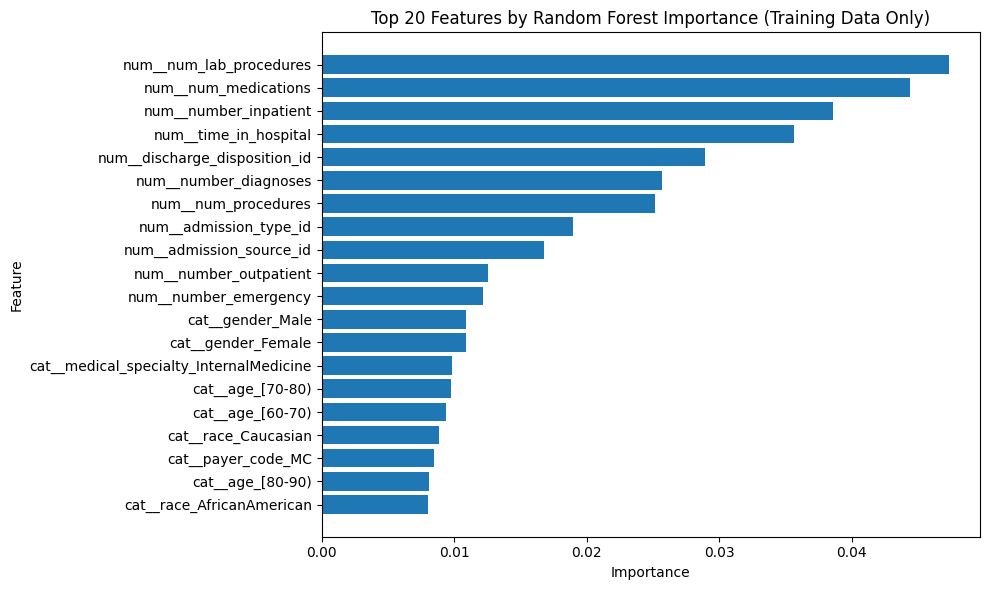

In [122]:
import matplotlib.pyplot as plt

top_plot = rf_importance_df.head(20).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top_plot["feature"], top_plot["importance"])
plt.title("Top 20 Features by Random Forest Importance (Training Data Only)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [123]:
# Merge MI and RF rankings for comparison
comparison_df = (
    mi_scores_df[["feature", "mutual_information"]]
    .merge(
        rf_importance_df[["feature", "importance"]],
        on="feature",
        how="inner"
    )
    .sort_values("importance", ascending=False)
)

comparison_df.head(15)

,feature,mutual_information,importance
1095,num__num_lab_procedures,0.000198,0.047320
1077,num__num_medications,0.000218,0.044384
1,num__number_inpatient,0.013108,0.038571
991,num__time_in_hospital,0.000328,0.035643
14,num__discharge_disposition_id,0.008407,0.028926
79,num__number_diagnoses,0.002857,0.025669
369,num__num_procedures,0.001422,0.025138
83,num__admission_type_id,0.002796,0.018971
35,num__admission_source_id,0.004324,0.016766
134,num__number_outpatient,0.002334,0.012549


In [124]:
comparison_path = DOCS_DIR / "mi_vs_rf_feature_comparison.csv"
comparison_df.to_csv(comparison_path, index=False)
print("Saved MI vs RF comparison to:", comparison_path)

Saved MI vs RF comparison to: /content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs/mi_vs_rf_feature_comparison.csv


**9. Feature Name Mapping for Model Interpretability**

The preprocessing pipeline produces a high-dimensional feature space after one-hot encoding categorical variables. To ensure interpretability of feature diagnostics and selection results, processed feature indices are mapped back to human-readable feature names generated during preprocessing in Notebook 02.

This section:

- Verifies alignment between processed matrices and feature names

- Attaches feature names to MI and Random Forest importance outputs

- Groups encoded features back to their original source variables for interpretation

No transformations or selections are applied in this step.

In [125]:
import numpy as np
import pandas as pd

assert X_train_processed.shape[1] == len(feature_names), (
    "Mismatch between processed feature matrix columns "
    "and number of feature names."
)

print("✅ Feature name alignment verified")
print("Total processed features:", len(feature_names))
print("Example feature names:", feature_names[:10])


✅ Feature name alignment verified
Total processed features: 2376
Example feature names: ['num__admission_type_id' 'num__discharge_disposition_id'
 'num__admission_source_id' 'num__time_in_hospital'
 'num__num_lab_procedures' 'num__num_procedures' 'num__num_medications'
 'num__number_outpatient' 'num__number_emergency' 'num__number_inpatient']


In [126]:
# Ensure MI dataframe has correct columns
mi_named_df = mi_scores_df.copy()
mi_named_df.columns = ["feature", "mutual_information"]

# Ensure RF dataframe has correct columns
rf_named_df = rf_importance_df.copy()
rf_named_df.columns = ["feature", "importance"]

display(mi_named_df.head(10))
display(rf_named_df.head(10))


,feature,mutual_information
0,cat__repaglinide_No,0.013446
1,num__number_inpatient,0.013108
2,cat__rosiglitazone_No,0.012321
3,cat__tolbutamide_No,0.012056
4,cat__chlorpropamide_No,0.011429
5,cat__glimepiride_No,0.011401
6,cat__acarbose_No,0.011090
7,cat__citoglipton_No,0.010894
8,cat__troglitazone_No,0.010657
9,cat__payer_code_MC,0.010550


,feature,importance
0,num__num_lab_procedures,0.047320
1,num__num_medications,0.044384
2,num__number_inpatient,0.038571
3,num__time_in_hospital,0.035643
4,num__discharge_disposition_id,0.028926
5,num__number_diagnoses,0.025669
6,num__num_procedures,0.025138
7,num__admission_type_id,0.018971
8,num__admission_source_id,0.016766
9,num__number_outpatient,0.012549


In [127]:
def extract_base_feature_name(feature_name: str) -> str:
    """
    Extract original feature name from encoded feature.
    Examples:
      'num__time_in_hospital' -> 'time_in_hospital'
      'cat__gender_Female'   -> 'gender'
    """
    if "__" in feature_name:
        feature_name = feature_name.split("__", 1)[1]
    # Remove category suffix for one-hot encoded features
    return feature_name.split("_")[0]

# Apply mapping
mi_named_df["base_feature"] = mi_named_df["feature"].apply(extract_base_feature_name)
rf_named_df["base_feature"] = rf_named_df["feature"].apply(extract_base_feature_name)

display(mi_named_df.head(10))


,feature,mutual_information,base_feature
0,cat__repaglinide_No,0.013446,repaglinide
1,num__number_inpatient,0.013108,number
2,cat__rosiglitazone_No,0.012321,rosiglitazone
3,cat__tolbutamide_No,0.012056,tolbutamide
4,cat__chlorpropamide_No,0.011429,chlorpropamide
5,cat__glimepiride_No,0.011401,glimepiride
6,cat__acarbose_No,0.011090,acarbose
7,cat__citoglipton_No,0.010894,citoglipton
8,cat__troglitazone_No,0.010657,troglitazone
9,cat__payer_code_MC,0.010550,payer


In [128]:
# Aggregate MI at base-feature level
mi_agg_df = (
    mi_named_df
    .groupby("base_feature", as_index=False)["mutual_information"]
    .sum()
    .sort_values("mutual_information", ascending=False)
)

# Aggregate RF importance at base-feature level
rf_agg_df = (
    rf_named_df
    .groupby("base_feature", as_index=False)["importance"]
    .sum()
    .sort_values("importance", ascending=False)
)

display(mi_agg_df.head(15))
display(rf_agg_df.head(15))


,base_feature,mutual_information
9,diag,1.155052
21,medical,0.042329
28,number,0.023184
29,payer,0.019940
12,gender,0.014170
32,repaglinide,0.013446
38,weight,0.013347
6,chlorpropamide,0.013289
13,glimepiride,0.013287
4,age,0.012912


,base_feature,importance
9,diag,0.397504
27,num,0.116842
28,number,0.088943
4,age,0.048578
21,medical,0.041985
3,admission,0.035737
34,time,0.035643
29,payer,0.031497
10,discharge,0.028926
19,insulin,0.023673


In [129]:
from pathlib import Path

DOCS_DIR = Path("/content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs")
DOCS_DIR.mkdir(parents=True, exist_ok=True)

mi_named_df.to_csv(DOCS_DIR / "mi_feature_level_encoded.csv", index=False)
rf_named_df.to_csv(DOCS_DIR / "rf_feature_level_encoded.csv", index=False)

mi_agg_df.to_csv(DOCS_DIR / "mi_feature_level_aggregated.csv", index=False)
rf_agg_df.to_csv(DOCS_DIR / "rf_feature_level_aggregated.csv", index=False)

print("✅ Saved feature name mapping and aggregated importance artefacts")

✅ Saved feature name mapping and aggregated importance artefacts


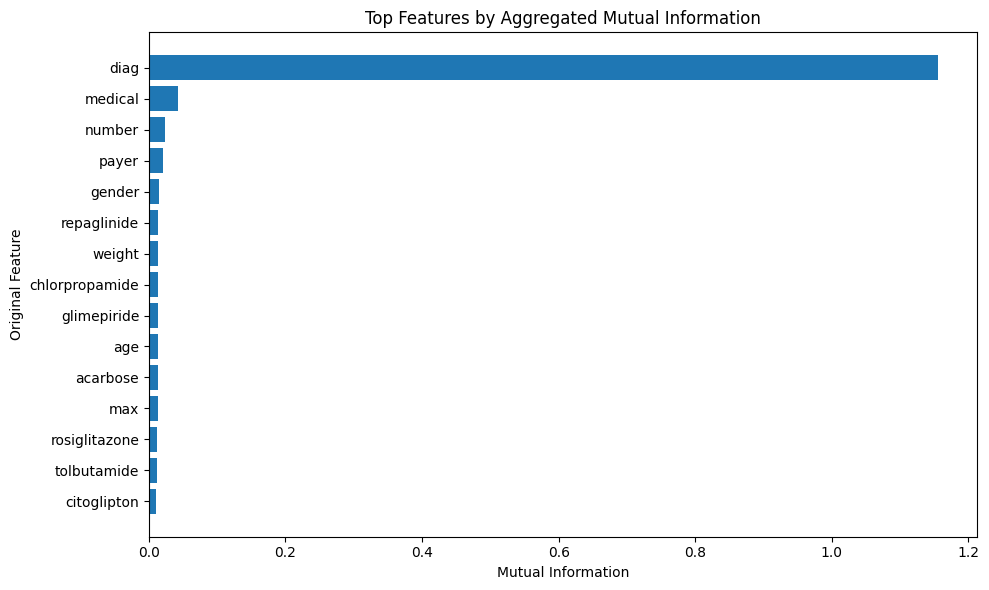

In [130]:
import matplotlib.pyplot as plt

top_mi_plot = mi_agg_df.head(15).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top_mi_plot["base_feature"], top_mi_plot["mutual_information"])
plt.title("Top Features by Aggregated Mutual Information")
plt.xlabel("Mutual Information")
plt.ylabel("Original Feature")
plt.tight_layout()
plt.show()

**10. Dimensionality Reduction: Principal Component Analysis (PCA)**

Principal Component Analysis (PCA) is applied to the processed training data only to:

- Assess the intrinsic dimensionality of the feature space
- Identify redundancy and correlation structure after encoding
- Support diagnostic understanding and visualization, not model training

Because the processed feature matrix is high-dimensional and sparse (due to one-hot encoding), PCA is implemented using TruncatedSVD, which is mathematically equivalent to PCA for centered data and appropriate for sparse matrices.

Important: PCA results here are diagnostic only. No dimensionality reduction is applied to the modeling pipeline at this stage.

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Number of components capped for diagnostics
N_COMPONENTS = min(100, X_train_processed.shape[1])

svd = TruncatedSVD(
    n_components=N_COMPONENTS,
    random_state=42
)

svd.fit(X_train_processed)

explained_var = svd.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

print("✅ TruncatedSVD fitted on training data only")
print("Components used:", N_COMPONENTS)
print("Cumulative explained variance (last component):", round(cum_explained_var[-1], 4))


✅ TruncatedSVD fitted on training data only
Components used: 100
Cumulative explained variance (last component): 0.9137


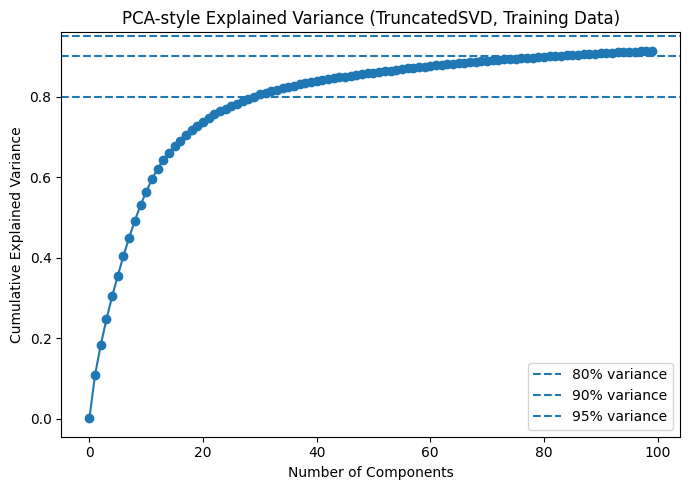

In [132]:
plt.figure(figsize=(7, 5))
plt.plot(cum_explained_var, marker="o")
plt.axhline(0.80, linestyle="--", label="80% variance")
plt.axhline(0.90, linestyle="--", label="90% variance")
plt.axhline(0.95, linestyle="--", label="95% variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA-style Explained Variance (TruncatedSVD, Training Data)")
plt.legend()
plt.tight_layout()
plt.show()


In [133]:
def components_for_threshold(cum_var, threshold):
    return int(np.argmax(cum_var >= threshold) + 1)

thresholds = [0.80, 0.90, 0.95]

pca_thresholds = {
    f"{int(t*100)}% variance": components_for_threshold(cum_explained_var, t)
    for t in thresholds
}

pd.DataFrame.from_dict(
    pca_thresholds,
    orient="index",
    columns=["Required Components"]
)

,Required Components
80% variance,31
90% variance,83
95% variance,1


In [134]:
from pathlib import Path

DOCS_DIR = Path("/content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs")
DOCS_DIR.mkdir(parents=True, exist_ok=True)

pca_diag_df = pd.DataFrame({
    "component": np.arange(1, len(explained_var) + 1),
    "explained_variance_ratio": explained_var,
    "cumulative_explained_variance": cum_explained_var
})

pca_diag_path = DOCS_DIR / "pca_truncatedsvd_diagnostics.csv"
pca_diag_df.to_csv(pca_diag_path, index=False)

print("✅ Saved PCA diagnostics to:", pca_diag_path)

✅ Saved PCA diagnostics to: /content/drive/MyDrive/JohnRaffyRaymundo_AIMCapstone2025/docs/pca_truncatedsvd_diagnostics.csv


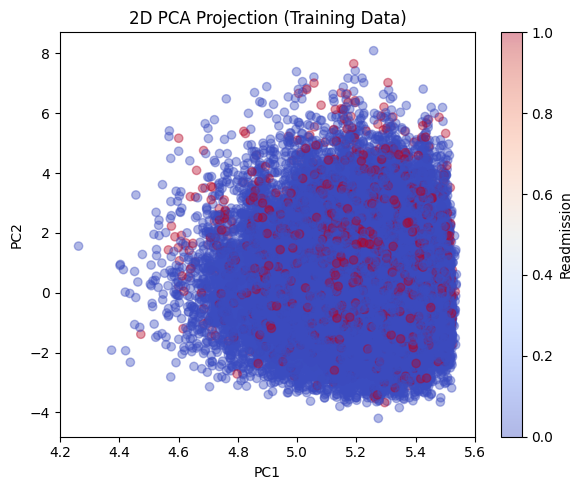

In [135]:
# Project to first two components for visualization
X_pca_2d = svd.transform(X_train_processed)[:, :2]

plt.figure(figsize=(6, 5))
plt.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=y_train,
    cmap="coolwarm",
    alpha=0.4
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection (Training Data)")
plt.colorbar(label="Readmission")
plt.tight_layout()
plt.show()

## 11. Dimensionality Reduction Strategy for Modeling

As demonstrated in Section 10, the processed training feature matrix is high-dimensional
and sparse due to one-hot encoding of categorical variables. To analyse intrinsic
dimensionality and redundancy, PCA-style decomposition was performed using TruncatedSVD,
which is appropriate for sparse matrices.

Based on the PCA diagnostics:
- A relatively large number of components is required to explain a high proportion of
  variance, indicating substantial feature redundancy.
- Variance accumulates slowly across components, which is typical for one-hot encoded
  healthcare data.

### Intended use of dimensionality reduction
Dimensionality reduction is considered **optional** and will be used selectively for:
- Diagnostic understanding of feature redundancy
- Potential compression for faster experimentation or visualization
- Comparative modeling experiments

### Modeling decision
We **do not force dimensionality reduction** as part of the default modeling pipeline.
Instead, in **Notebook 04**, we will:
- Train baseline models on the full feature space
- Optionally compare performance with SVD-compressed features
- Select the final approach based on empirical performance and interpretability trade-offs

This strategy preserves predictive signal while allowing flexibility in model design.


## 12. Interpretation & Key Insights from EDA and Feature Diagnostics

Mapping processed feature indices back to their original feature names confirms that
healthcare utilisation–related variables (e.g., prior inpatient visits, number of
medications, and length-of-stay proxies) consistently rank highly across both
filter-based (Mutual Information) and embedded (Random Forest) feature selection methods.

Key insights from this analysis include:
- Numeric features related to healthcare utilisation show meaningful association with
  30-day readmission risk.
- Several categorical features demonstrate varying readmission rates across patient
  subgroups.
- Correlation analysis highlights redundancy among certain numeric variables, suggesting
  potential multicollinearity.
- PCA diagnostics indicate that a reduced set of components can capture a large proportion
  of variance, supporting dimensionality reduction if required.

These findings improve interpretability, validate feature engineering decisions made in
Notebook 02, and inform downstream model selection and regularisation strategies.



## 13. Summary & Transition to Notebook 04

In this notebook, we:
- Conducted leakage-safe exploratory data analysis using training data only
- Examined numeric and categorical feature distributions and their relationship with the target
- Assessed feature redundancy and multicollinearity
- Applied filter-based and embedded feature selection methods
- Performed PCA-style diagnostics to understand feature-space dimensionality

In the next notebook (**Notebook 04**), we will focus on model implementation and comparison,
including baseline models, tree-based ensembles, and evaluation using clinically relevant
performance metrics.